In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset (update path to your Kaggle input folder)
df = pd.read_csv('/kaggle/input/ids-last-5y-csv55/ids_last_5y.csv')

# Quick look
print('Rows, cols:', df.shape)
df.head()

Rows, cols: (76820, 10)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,Country Name,Country Code,Series Name,Series Code,2018,2019,2020,2021,2022
0,0,Afghanistan,AFG,Average grace period on new external debt comm...,DT.GPA.DPPG,0.0,17.9041,0.0,0.0,NaN
1,1,Afghanistan,AFG,Average grace period on new external debt comm...,DT.GPA.OFFT,0.0,17.9041,0.0,0.0,NaN
2,2,Afghanistan,AFG,Average grace period on new external debt comm...,DT.GPA.PRVT,0.0,0.0000,0.0,0.0,NaN
3,3,Afghanistan,AFG,Average grant element on new external debt com...,DT.GRE.DPPG,0.0,73.0790,0.0,0.0,NaN
4,4,Afghanistan,AFG,Average grant element on new external debt com...,DT.GRE.OFFT,0.0,73.0790,0.0,0.0,NaN


In [8]:
# Cell 3: Cleaning and feature engineering
# Drop unused columns
df_clean = df.drop(columns=['Unnamed: 0', 'Country Name', 'Country Code', 'Series Name'])

# Keep rows where target exists
df_clean = df_clean.dropna(subset=['2022']).copy()

# Fill missing values in 2018-2021 with column mean
cols = ['2018', '2019', '2020', '2021', '2022']
df_clean[cols] = df_clean[cols].apply(pd.to_numeric, errors='coerce')
df_clean[['2018','2019','2020','2021','2022']] = df_clean[['2018','2019','2020','2021','2022']].fillna(df_clean[['2018','2019','2020','2021','2022']].mean())

# Encode Series Code (recommended 5th feature)
le = LabelEncoder()
df_clean['SeriesCode_Encoded'] = le.fit_transform(df_clean['Series Code'])

# Optional derived feature (helps linear models): mean of previous years
df_clean['Avg_2018_2021'] = df_clean[['2018','2019','2020','2021']].mean(axis=1)

# Final features (we will use 5 features: 2018-2021 + SeriesCode_Encoded)
X = df_clean[['2018','2019','2020','2021','SeriesCode_Encoded']]
y = df_clean['2022']

print('After cleaning:', X.shape)
X.head()

After cleaning: (12860, 5)


,2018,2019,2020,2021,SeriesCode_Encoded
98,32675060.7,32780041.6,28700402.1,1.923400e+07,108
99,39785060.7,39807041.6,34557402.1,1.923400e+07,111
102,7110000.0,7027000.0,5857000.0,6.496635e+09,113
103,32675060.7,32780041.6,28700402.1,1.923400e+07,114
104,32675060.7,32780041.6,28700402.1,1.923400e+07,109


In [9]:
# Cell 4: Scaling (recommended when combining numeric ranges)
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['2018','2019','2020','2021']] = scaler.fit_transform(X[['2018','2019','2020','2021']])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (10288, 5) Test shape: (2572, 5)


In [10]:
# Cell 5: Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Metrics helper
def regression_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

metrics_train = regression_metrics(y_train, pred_train)
metrics_test = regression_metrics(y_test, pred_test)

print('Train metrics:', metrics_train)
print('Test metrics: ', metrics_test)

Train metrics: {'MAE': 3078236948.481543, 'MSE': 2.3145219642622686e+20, 'RMSE': 15213553050.69223, 'R2': 0.8320400958162071}
Test metrics:  {'MAE': 2935642769.050363, 'MSE': 1.1540680879979399e+20, 'RMSE': 10742756108.17792, 'R2': 0.9202037345586923}


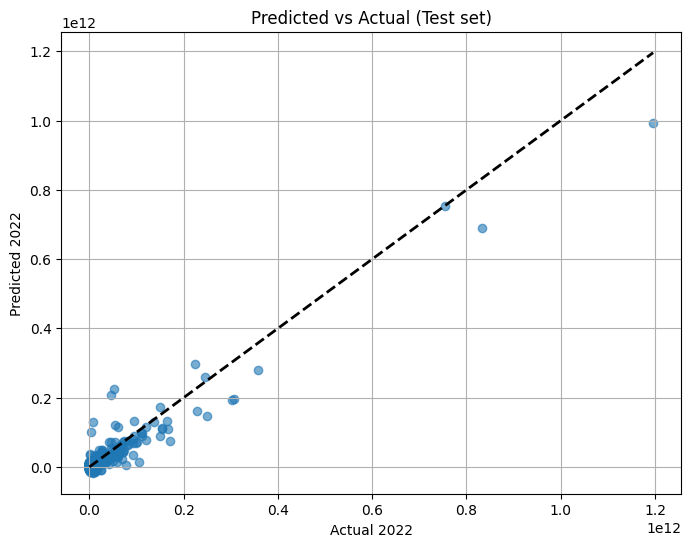

In [11]:
# Cell 6: Predicted vs Actual for test set
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual 2022')
plt.ylabel('Predicted 2022')
plt.title('Predicted vs Actual (Test set)')
plt.grid(True)
plt.show()

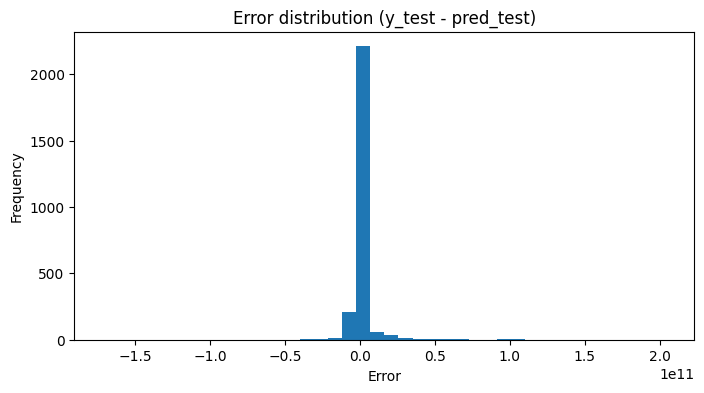

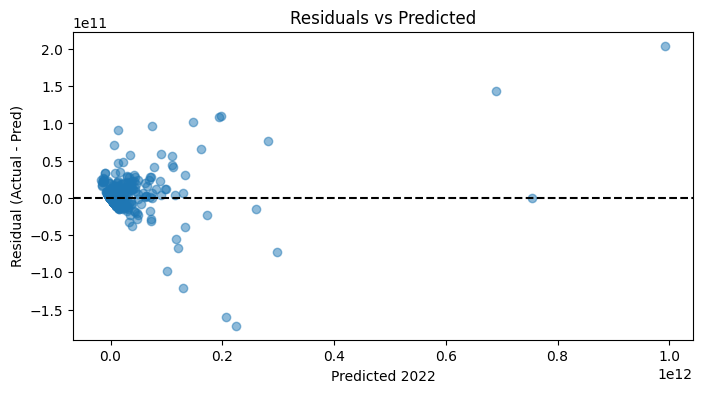

In [12]:
# Cell 7: Error distribution and residual plot
errors = y_test - pred_test

plt.figure(figsize=(8,4))
plt.hist(errors, bins=40)
plt.title('Error distribution (y_test - pred_test)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(pred_test, errors, alpha=0.5)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicted 2022')
plt.ylabel('Residual (Actual - Pred)')
plt.title('Residuals vs Predicted')
plt.show()

In [13]:
# Cell 8: Coefficients (for linear regression)
coefs = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model.coef_
}).sort_values(by='coefficient', key=abs, ascending=False)
coefs

,feature,coefficient
3,2021,6.607428e+10
2,2020,-6.165014e+10
1,2019,3.088485e+10
0,2018,-2.010030e+09
4,SeriesCode_Encoded,1.351265e+07


In [14]:
# Cell 9: Save trained model (optional)
import joblib
joblib.dump(model, 'linear_regression_2022_model.pkl')
print('Saved model to linear_regression_2022_model.pkl')

Saved model to linear_regression_2022_model.pkl
